In [10]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt



# 1. Chargement et prétraitement

In [11]:

df_raw = pd.read_csv('healthcare-dataset-stroke-data.csv')
df_raw.drop(columns=['id'], inplace=True)
df_raw.fillna({'bmi': df_raw['bmi'].median()}, inplace=True)


##  Discrétisation

In [12]:

df_raw['age_bin'] = pd.cut(
    df_raw['age'],
    bins=[0, 30, 45, 60, 100],
    labels=['0-30', '31-45', '46-60', '61+']
)
df_raw['bmi_bin'] = pd.cut(
    df_raw['bmi'],
    bins=[0, 18.5, 25, 30, df_raw['bmi'].max()],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)
df_raw['glucose_bin'] = pd.qcut(
    df_raw['avg_glucose_level'],
    q=4,
    labels=['Low', 'Mid-low', 'Mid-high', 'High']
)

print("Distribution stroke:\n", df_raw['stroke'].value_counts(normalize=True))

Distribution stroke:
 stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


# 2. Construction des transactions

In [13]:

cols = [
    'gender', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'smoking_status',
    'age_bin', 'bmi_bin', 'glucose_bin'
]

transactions = []
for _, row in df_raw.iterrows():
    items = [f"{col}={row[col]}" for col in cols]
    items.append(f"stroke={int(row['stroke'])}")
    transactions.append(items)

print("Exemple de 5 transactions:", transactions[:5])




Exemple de 5 transactions: [['gender=Male', 'hypertension=0', 'heart_disease=1', 'ever_married=Yes', 'work_type=Private', 'Residence_type=Urban', 'smoking_status=formerly smoked', 'age_bin=61+', 'bmi_bin=Obese', 'glucose_bin=High', 'stroke=1'], ['gender=Female', 'hypertension=0', 'heart_disease=0', 'ever_married=Yes', 'work_type=Self-employed', 'Residence_type=Rural', 'smoking_status=never smoked', 'age_bin=61+', 'bmi_bin=Overweight', 'glucose_bin=High', 'stroke=1'], ['gender=Male', 'hypertension=0', 'heart_disease=1', 'ever_married=Yes', 'work_type=Private', 'Residence_type=Rural', 'smoking_status=never smoked', 'age_bin=61+', 'bmi_bin=Obese', 'glucose_bin=Mid-high', 'stroke=1'], ['gender=Female', 'hypertension=0', 'heart_disease=0', 'ever_married=Yes', 'work_type=Private', 'Residence_type=Urban', 'smoking_status=smokes', 'age_bin=46-60', 'bmi_bin=Obese', 'glucose_bin=High', 'stroke=1'], ['gender=Female', 'hypertension=1', 'heart_disease=0', 'ever_married=Yes', 'work_type=Self-employe

# 3. Encodage transactionnel

In [14]:

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_bin = pd.DataFrame(te_ary, columns=te.columns_)


# 9. Analyse paramétrique

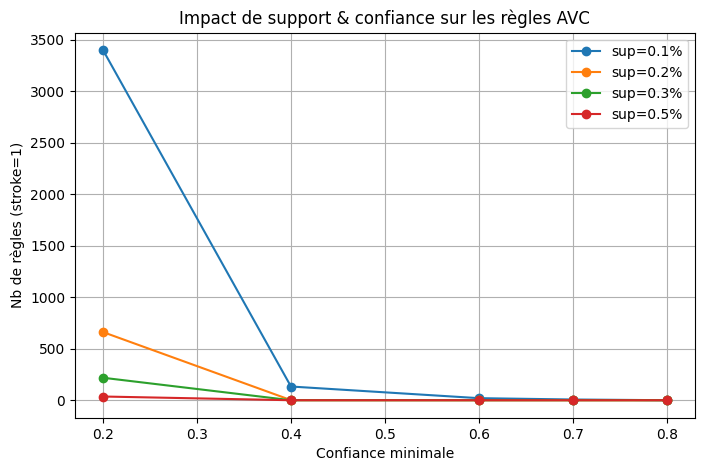

confidence   0.2  0.4  0.6  0.7  0.8
support                             
0.001       3397  133   20    7    0
0.002        661    1    0    0    0
0.003        218    0    0    0    0
0.005         36    0    0    0    0


In [16]:

support_levels    = [0.001, 0.002, 0.003, 0.005]
confidence_levels = [0.2, 0.4, 0.6, 0.7,0.8]

def count_rules(min_sup, min_conf):
    fi = apriori(df_bin, min_support=min_sup, use_colnames=True)
    rs = association_rules(fi, metric='confidence', min_threshold=min_conf)
    rs = rs[rs['consequents']
            .apply(lambda s: 'stroke=1' in s)]
    return len(rs)

results = []
plt.figure(figsize=(8,5))
for sup in support_levels:
    counts = []
    for conf in confidence_levels:
        n = count_rules(sup, conf)
        counts.append(n)
        results.append({'support': sup, 'confidence': conf, 'n_rules': n})
    plt.plot(confidence_levels, counts, marker='o', label=f'sup={sup:.1%}')

plt.xlabel('Confiance minimale')
plt.ylabel('Nb de règles (stroke=1)')
plt.title('Impact de support & confiance sur les règles AVC')
plt.legend()
plt.grid(True)
plt.show()

res_df = pd.DataFrame(results)
print(res_df.pivot(index='support', columns='confidence', values='n_rules'))


# 4. Itemsets fréquents

In [17]:

sup_min = 0.001  # 0.1 % (événement rare)
freq_items = apriori(df_bin, min_support=sup_min, use_colnames=True)

# 5. Règles d'association (stroke=1)

In [18]:

conf_min = 0.6    # seuil de confiance bas pour capter l’AVC rare
rules = association_rules(freq_items, metric='confidence', min_threshold=conf_min)
print(f"\nRègles vers tous les regles trouver avant métriques : {len(rules)}")
rules = rules[rules['consequents']
              .apply(lambda s: 'stroke=1' in s)].copy()
print(f"\nRègles vers stroke=1 avant métriques : {len(rules)}")


Règles vers tous les regles trouver avant métriques : 1437210

Règles vers stroke=1 avant métriques : 20


# 6. Métriques Lenca et al.

In [19]:

def bayes_factor(row):
    antecedents = list(row['antecedents'])
    mask = df_bin[antecedents].all(axis=1)
    p1 = df_bin[mask]['stroke=1'].mean()
    p0 = df_bin[~mask]['stroke=1'].mean()
    return (p1 / p0) if p0 > 0 else float('inf')

def pdi(row):
    return row['support'] - row['antecedent support'] * row['consequent support']

def intimp(row):
    return (row['support'] - row['consequent support']) / row['consequent support']

rules['BayesFactor'] = [bayes_factor(r) for _, r in rules.iterrows()]
rules['PDI']         = [pdi(r)          for _, r in rules.iterrows()]
rules['INTIMP']      = [intimp(r)       for _, r in rules.iterrows()]

# 7. Diagnostic avant filtrage

In [20]:

thresh = {
    'lift'        : 1.0,
    'BayesFactor': 1.0,
    'PDI'         : 0.0,
    'INTIMP'      : 0.0
}

print("\nRésumé des métriques :")
print(rules[['lift','BayesFactor','PDI','INTIMP']].describe())

print("\nRègles satisfaisant chaque seuil :")
for m, t in thresh.items():
    print(f" - {m} ≥ {t} → {(rules[m] >= t).sum()} règles")


Résumé des métriques :
            lift  BayesFactor        PDI     INTIMP
count  20.000000    20.000000  20.000000  20.000000
mean   15.790746    14.385069   0.001177  -0.970493
std     5.120628     1.294252   0.000145   0.007690
min    12.313253    12.592593   0.001079  -0.975904
25%    12.951877    13.310005   0.001088  -0.975904
50%    14.878514    14.373290   0.001102  -0.972307
75%    16.035991    15.746914   0.001267  -0.967429
max    35.486111    16.394399   0.001618  -0.944444

Règles satisfaisant chaque seuil :
 - lift ≥ 1.0 → 20 règles
 - BayesFactor ≥ 1.0 → 20 règles
 - PDI ≥ 0.0 → 20 règles
 - INTIMP ≥ 0.0 → 0 règles


# 8. Filtrage final

In [21]:

filtered = rules[
    (rules['lift']        >= thresh['lift']) &
    (rules['BayesFactor'] >= thresh['BayesFactor']) &
    (rules['PDI']         >= thresh['PDI']) 
    #&(rules['INTIMP']      >= thresh['INTIMP'])
].sort_values('lift', ascending=False)

filtered.to_csv('stroke_association_rules.csv', index=False)
print(f"\nRègles retenues après filtrage : {len(filtered)}")


Règles retenues après filtrage : 20
